In [16]:
# Cell 1: Data Preparation
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the path to the data folder on your local PC
data_folder = r"D:\DATA"

# Define classes to capture
classes_to_capture = ["A", "B", "C"]

# Function to preprocess images
def preprocess_images(folder):
    images = []
    labels = []

    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for img_name in os.listdir(class_folder)[:1000]:  # Take first 1000 images per class
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read images in color
            img = cv2.resize(img, (224, 224))  # Resize to VGG input size
            img = img[..., ::-1]  # Convert BGR to RGB
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(classes_to_capture.index(class_name))

    return np.array(images), np.array(labels)

# Preprocess data
data_images, data_labels = preprocess_images(data_folder)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [17]:
# Cell 2: Model Development
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
vgg_base.trainable = False

# Add a custom classification head
model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes_to_capture), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
# Cell 3: Training with Reduced Batch Size
# Define batch size
batch_size = 32

# Train the model in smaller batches
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy: 0.7507 - loss: 1.4744 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.9986 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 295s 4s/step - accuracy: 0.9985 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 9.0728e-04
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9963 - val_loss: 0.0029
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9963 - val_loss: 0.0028
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - accuracy: 1.0000 - loss: 7.7564e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.

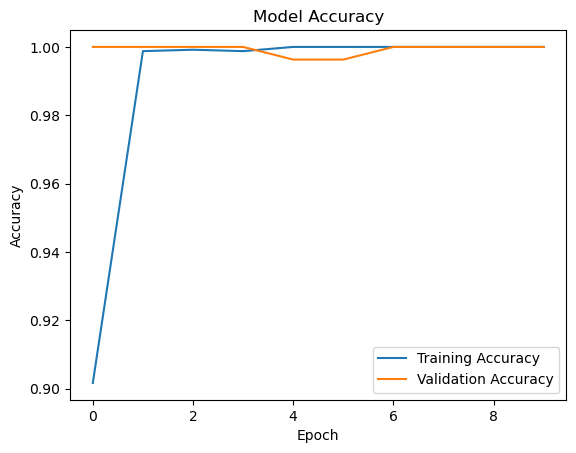

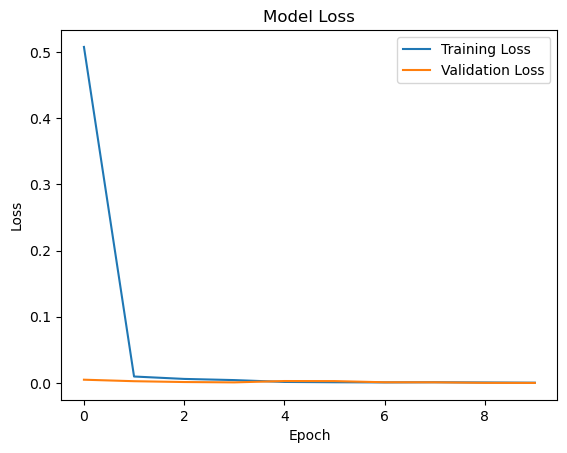

In [19]:
# Cell 4: Model Evaluation and Visualization
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Cell 5: Model Evaluation and Saving
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Save the trained model
model.save("hand_signs_model_vgg_updated.h5")
print("Trained model saved successfully.")


10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 1.0000 - loss: 2.4027e-05


Test Accuracy: 1.0
Trained model saved successfully.


In [21]:
# Cell 6: Real-time Inference
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("hand_signs_model_vgg_updated.h5")

# Define the classes
classes_to_capture = ["A", "B", "C"]

# Function to preprocess the captured frame
def preprocess_frame(frame):
    # Resize the frame to match the input size of the model
    resized_frame = cv2.resize(frame, (224, 224))
    # Convert the frame to RGB (VGG model takes RGB images)
    resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # Normalize the pixel values
    normalized_frame = resized_frame / 255.0
    # Expand dimensions to match the input shape of the model and add batch dimension
    preprocessed_frame = np.expand_dims(normalized_frame, axis=0)
    return preprocessed_frame

# Open the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)
    
    # Predict the sign
    prediction = model.predict(preprocessed_frame)
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    # Get the class label
    predicted_label = classes_to_capture[predicted_class_index]
    
    # Display the predicted letter on the frame
    cv2.putText(frame, predicted_label, (frame.shape[1] - 150, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display the frame with the predicted letter
    cv2.imshow('Sign Language Recognition', frame)
    
    # Check for the 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 